# ASR Assignment 2019-20

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2019-20/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/Ore-an/asr_lab3/blob/master/asr_lab3.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [13]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import time

In [3]:
import numpy as np
import math

def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)


def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        sl_weight = fst.Weight('log', -math.log(0.1))  # weight for self-loop
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        next_weight = fst.Weight('log', -math.log(0.9)) # weight to next state
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        current_state = next_state
        
    return current_state

In [4]:
def generate_word_wfst(word):
    """ Generate a WFST for any word in the lexicon, composed of 3-state phone WFSTs.
        This will currently output word labels.  
        Exercise: could you modify this function and the one above to output a single phone label instead?
    
    Args:
        word (str): the word to generate
        
    Returns:
        the constructed WFST
    
    """
    f = fst.Fst('log')
    
    # create the start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    current_state = start_state
    
    # iterate over all the phones in the word
    for phone in lex[word]:   # will raise an exception if word is not in the lexicon
        
        current_state = generate_phone_wfst(f, current_state, phone, 3)
    
        # note: new current_state is now set to the final state of the previous phone WFST
        
    f.set_final(current_state)
    
    return f

In [5]:
def generate_multiple_words_wfst(word_list):
    """ Generate a WFST for any word in the lexicon, composed of 3-state phone WFSTs.
        This will currently output word labels.  
        Exercise: could you modify this function and the one above to output a single phone label instead?
    
    Args:
        word (str): the word to generate
        
    Returns:
        the constructed WFST
    
    """
    if isinstance(word_list, str):
        word_list = word_list.split()
    f = fst.Fst("log")
    start_state = f.add_state()
    f.set_start(start_state)
    for word in word_list:
        # create the start state
        
        current_state = f.add_state()
        
        f.add_arc(start_state, fst.Arc(0, 0, fst.Weight("log",-math.log(1/len(word_list))), current_state))
    
        # iterate over all the phones in the word
        for phone in lex[word]:   # will raise an exception if word is not in the lexicon
        
            current_state = generate_phone_wfst(f, current_state, phone, 3)
            
    
            # note: new current_state is now set to the final state of the previous phone WFST
        
        f.add_arc(current_state, fst.Arc(0, 0, fst.Weight("log",-math.log(1)), start_state))
    
        f.set_final(current_state)
    
    return f

In [14]:
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        # forward computation counter
        self.forward_counter = 0
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
    
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []
        self.backtracing = []
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
        for t in range(self.om.observation_length()+1):
            self.backtracing.append([self.NLL_ZERO]*self.f.num_states())
        #self.backtracing = [[self.NLL_ZERO]*(self.om.observation_length()+1)]*self.f.num_states()
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(range(self.f.num_states())) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                  
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        
        
        states_to_traverse = list(range(self.f.num_states())) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)

            for arc in self.f.arcs(i):
                
                # increase the forward counter by 1
                self.forward_counter += 1
                
                if arc.ilabel != 0:
                    
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t-1][i] + float(arc.weight) - self.om.log_observation_probability(state_table.find(arc.ilabel),t):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t-1][i] + float(arc.weight) - self.om.log_observation_probability(state_table.find(arc.ilabel),t)
                        self.backtracing[t][j] = (i,state_table.find(arc.ilabel),phone_table.find(arc.olabel))
                else:
                    self.traverse_epsilon_arcs(t)
                

    
    def finalise_decoding(self):
        self.P = self.NLL_ZERO
        states_to_transverse = list(range(self.f.num_states()))
        while states_to_transverse:
            
            i = states_to_transverse.pop(0)
            
            for arc in self.f.arcs(i):
                if arc.ilabel != 0:
                    j = arc.nextstate   # ID of next state  
                    
                
                    if self.P > self.V[self.om.observation_length()-1][i]+float(arc.weight) - self.om.log_observation_probability(state_table.find(arc.ilabel),self.om.observation_length()-1):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.P = self.V[self.om.observation_length()-1][i]+float(arc.weight) - self.om.log_observation_probability(state_table.find(arc.ilabel),self.om.observation_length()-1)
                        self.fin_arg = i
                        self.last_output = phone_table.find(arc.olabel)
                  
            
    
    def decode(self):
        
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            t+=1
        
        self.finalise_decoding()
    
    def backtrace(self):
        
        # TODO - exercise 
        
        # complete code to trace back through the
        # best state sequence
        
        # You'll need to create a structure B_j(t) to store the 
        # back-pointers (see lectures), and amend the functions above to fill it.
        #best_state_sequence = self.backtracing[self.fin_arg]
        best_last_state = self.backtracing[-1][self.fin_arg][0]
        # print(best_last_state)
        best_state_sequence = []
        output_word = [self.last_output]
        for t in range(1,self.om.observation_length()+1):
            best_state_sequence.append(self.backtracing[-t][best_last_state][1])
            output_word.append(self.backtracing[-t][best_last_state][2])
            best_last_state = self.backtracing[-t][best_last_state][0]
            
         #   print(best_last_state)
        best_state_sequence = best_state_sequence[::-1]
        output_word = [v for v in output_word[::-1] if v!='<eps>']
        return best_state_sequence, output_word

In [7]:
def create_wfst():
    f = generate_multiple_words_wfst([k for k in lex.keys()])
    return f

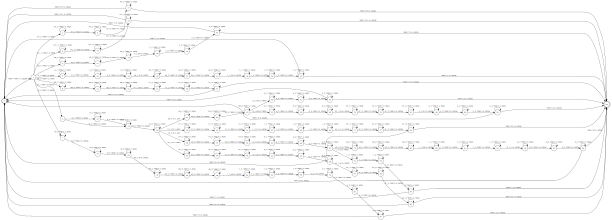

In [8]:
f = create_wfst()
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

In [9]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext()[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


f = create_wfst()
decoder = MyViterbiDecoder(f, '')

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
    
    decoder.om.load_audio(wav_file)
    
    decoder.decode()
    (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                               # to return the words along the best path
    
    transcription = read_transcription(wav_file)
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    
    print(error_counts, word_count)     # you'll need to accumulate these to produce an overall Word Error Rate


Exception: 

## Task 1 - Initial systems

In [12]:
len(glob.glob('/group/teaching/asr/labs/recordings/*.wav'))

51

In [17]:
help(f.states)

Help on built-in function states:

states(...) method of pywrapfst._MutableFst instance
    states(self)
    
    Returns an iterator over all states in the FST.
    
    Returns:
      A StateIterator object for the FST.
    
    See also: `arcs`, `mutable_arcs`.



In [26]:
def count_states_arcs (f):
    '''
    Count the number of states and arcs in an wfst
    type f pywrapfst
    para f the wfst to count the number of states and arcs for
    '''
    num_states = 0
    num_arcs = 0
    
    for state in f.states():
        num_states += 1

        for arc in f.arcs(state):
            num_arcs += 1

            
    return num_states,num_arcs
            
count_state_arcs(f)

(97, 213)

In [ ]:
def run_exp():
    '''
    Run a test on the test data, record the WER, speed and memory cost.
    '''
    f = create_wfst()
    decoder = MyViterbiDecoder(f, '')
    
    # store the error counts and word counts
    tot_errors,tot_words = 0,0
    
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
    
        decoder.om.load_audio(wav_file)
        
        # start a timer
        start = time.time()
        
        decoder.decode()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                                   # to return the words along the best path
        # stop the timer
        end = time.time()
        time_cost = end - start
        
        # save the forward computation counter
        computation_counter = decoder.forward_counter
        
        # save the number states and arcs
        num_states,num_arcs = count_states_arcs(f)
        
        transcription = read_transcription(wav_file)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())
        
        # increase the total error and word count
        tot_errors += error_counts
        tot_words += word_count

        print("""
        Run time: {}, 
        Number of forward computations: {},
        Number of states and arcs: {} {},
        Number of errors {} in {} words
        """.format(time_cost,num_states,num_arcs,tot_errors,tot_words))     # you'll need to accumulate these to produce an overall Word Error Rate

In [30]:
a=23
print("""
hi
mu{}
""".format(a))


hi
mu23



### Overall WER

### Speed (time/ the number of forward computations)

### memory (the number of states and arcs)

## Task2 - System tuning

## Task3 - Pruning

## Task4 - Advanced topics